In [1]:
#import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

from itertools import count
from collections import namedtuple


In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from scipy.spatial.distance import euclidean
import numpy as np
from numpy.random import randint
from itertools import permutations
from random import shuffle

import matplotlib.animation as animation
from IPython.display import HTML

"""
Actions:
    -Draw vertex
    -Measure distance
    -Measure angle
"""
# DEFINE ENVIRONMENT
class GeometryEnvironment():
    def __init__(self):
        self.reset()

    def place_vertex(self, bead_index, vertex_index):
        self.bead_set[bead_index] = vertex_index

    def measure_distance(self, u, v):
        return euclidean(u, v)
    
    def reset(self):
        self.bead_set = np.array([(randint(low=1, high=100), randint(low=1, high=100)) for i in range(2)])
        self.defining_state = (randint(low=1, high=100), randint(low=1, high=100))
        self.answer = 0
        self.correct_answer = np.sqrt(self.defining_state[0]**2 + self.defining_state[1]**2)
    
    def step(self, action):
        # if distance should be measured
        #print("beads at start of step", self.bead_set)
        # convert tensor to format which can be manipulated
        if (action.requires_grad):
            action = action.clone().detach().numpy().T
        action_index = action[0]
        action_vertex = (action[1], action[2])
        if (action_index < -5):
            self.answer = self.measure_distance(self.bead_set[0], self.bead_set[1])
        else:
            action_index = 0 if action_index < 5 else 1
            self.place_vertex(action_index, action_vertex)
        reward = 1 / (np.abs(self.answer - self.correct_answer)**2)
        done = self.answer == self.correct_answer
        #print("beads at end of step", self.bead_set)
        #print("distance: ", self.measure_distance(self.bead_set[0], self.bead_set[1]))
        return self.get_state(), reward, done, -1
    
    def get_state(self):
        a = np.array(self.defining_state)
        b = np.array(self.bead_set[0])
        c = np.array(self.bead_set[1])
        nump = np.concatenate((a, b, c))
        t_state = torch.tensor(nump, dtype=torch.long)
        t_state = t_state.float().flatten()
        t_state.requires_grad = True
        return t_state
    
    def render(self):
        #print("Answer: ", self.answer)
        vertices = np.array([self.vertex_set[(self.bead_set[0])], self.vertex_set[(self.bead_set[1])]])
        #print(vertices)
        x, y = vertices.T
        plt.scatter(x, y)
        plt.show()
    
    def sample_action_space(self):
        action_type = float(random.randint(0, 2))
        return torch.tensor([action_type, float(randint(low=1, high=100)), float(randint(low=1, high=100))], requires_grad=True)
    
    def get_distances(self):
        # self.answer,
        return self.measure_distance(self.bead_set[0], self.bead_set[1]), self.correct_answer


In [10]:
# REPLAY MEMORY DEFINITION
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Problems:

-Need to provide float args to vertex position (x and y)

-Need to provide index argument to vertex position

-Need to provide index arguments to distance measurement



In [11]:
# DEFINE THE NETWORK
# TODO: replace CNN with linear learner

def print_with_extreme_prejudice(num):
    print("Fuck you you fucking piece of shit", num)

class Actor(nn.Module):
    def __init__(self, input_dimension, output_dimension):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(input_dimension, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.head = nn.Linear(32, output_dimension)

    # Called with either one element to determine next action, or a batch
    # during optimization
    # Returns a distribution over the possible actions tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.float()
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        self.out = self.head(x.view(1, x.size(0)))[0]
        return  self.out # self.head(x.view(x.size(0), -1))

class Critic(nn.Module):
    def __init__(self, input_dimension, output_dimension):
        super(Critic, self).__init__()

        """
        self.fc1 = nn.Linear(input_dimension, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.head = nn.Linear(32, output_dimension)
        
        """
        self.state_input = torch.randn((1, 6), requires_grad=True)

        self.state1 = nn.Linear(6, 32)  # 6*6 from image dimension
        self.state2 = nn.Linear(32, 64)

        self.action_input = torch.randn((1, 3), requires_grad=True)
        self.action_input.retain_grad()
        self.action1 = nn.Linear(3, 32)  # 6*6 from image dimension

        self.merged1 = nn.Linear(96, 32)

        self.head = nn.Linear(32, output_dimension)
        self.out = torch.randn((1), requires_grad=True)

    # Called with either one element to determine next action, or a batch
    # during optimization
    # Returns a distribution over the possible actions tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        self.action_input.register_hook(print_with_extreme_prejudice)
        x = x.float()
        #print(x.shape)
        self.state_input = x[0:6].clone()
        x_state = F.relu(self.state1(self.state_input))
        x_state = F.relu(self.state2(x_state))

        self.action_input = x[6:10].clone()
        x_action = F.relu(self.action1(self.action_input))

        x = torch.cat((x_state, x_action))
        x = F.relu(self.merged1(x))
        self.out = self.head(x.view(-1, x.size(0))) # self.head(x.view(x.size(0), -1))
        return self.out

In [12]:
import random
from collections import deque
def clone_tensors(item_list):
    new_items = []
    for item in item_list:
        new_items.append(item.clone() if torch.is_tensor(item) else item)
    return new_items

class ActorCritic:
    def __init__(self, env):
        self.env  = env

        self.action_dimension = 3
        self.environment_dimension = 6     
        
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = .995
        self.gamma = .95
        self.tau   = .125
        self.memory = deque(maxlen=2000)

        # ===================================================================== #
        #                               Actor Model                             #
        # Chain rule: find the gradient of changing the actor network params in #
        # getting closest to the final value network predictions, i.e. de/dA    #
        # Calculate de/dA as = de/dC * dC/dA, where e is error, C critic, A act #
        # ===================================================================== #

        self.memory = deque(maxlen=2000)

        self.actor_model = Actor(self.environment_dimension, self.action_dimension).float()
        self.target_actor_model = Actor(self.environment_dimension, self.action_dimension).float()

        self.target_actor_model.load_state_dict(self.actor_model.state_dict())
        self.target_actor_model.eval()

        self.actor_optimizer = optim.Adam(self.actor_model.parameters())
        
        #print(self.actor_model.state_dict())
        """
        self.actor_critic_grad = tf.placeholder(tf.float32, 
            [None, self.env.action_space.shape[0]]) # where we will feed de/dC (from critic)
        
        actor_model_weights = self.actor_model.trainable_weights
        self.actor_grads = tf.gradients(self.actor_model.output, 
            actor_model_weights, -self.actor_critic_grad) # dC/dA (from actor)
        
        grads = zip(self.actor_grads, actor_model_weights)

        
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)
         optimizer = optim.Adam(policy_net.parameters())
         """

        # ===================================================================== #
        #                              Critic Model                             #
        # ===================================================================== #        

        self.critic_model = Critic(self.action_dimension + self.environment_dimension, 1).float()
        self.target_critic_model = Critic(self.action_dimension + self.environment_dimension, 1).float()

        self.target_critic_model.load_state_dict(self.critic_model.state_dict())
        self.target_critic_model.eval()

        #self.critic_grads =  torch.autograd.grad(self.critic_model.head, self.critic_model.action_input)

        self.critic_optimizer = optim.Adam(self.critic_model.parameters())
        #self.critic_optimizer = optim.RMSprop(self.actor_model.parameters())

        """
        self.critic_grads = tf.gradients(self.critic_model.output, self.critic_action_input) # where we calcaulte de/        dC for feeding above
        optimizer = optim.Adam(policy_net.parameters())
        """
        
    # ===================================================================== #
    #                              Training                                 #
    # ===================================================================== #    

    def remember(self, cur_state, action, reward, new_state, done):
        self.memory.append([cur_state, action, reward, new_state, done])
    
    def _train_actor(self, samples):
        for real_sample in samples:
            sample = clone_tensors(real_sample)
            # Want to get critic grad, but with respect to the predicted action as the action input
            cur_state, action, reward, new_state, _ = sample

            # get action input
            #self.actor_optimizer.zero_grad()
            predicted_action = self.actor_model(cur_state)
            
            # get critic predictions
            critic_input = torch.cat((cur_state, predicted_action))
            expected_rewards = self.critic_model(critic_input)

            prediction_critic_grad=torch.autograd.grad(self.critic_model.out, self.critic_model.action_input, grad_outputs=expected_rewards)[0].clone()

            actor_model_weights = self.actor_model.parameters()
            
            # Compute actor gradients

            self.actor_grads = torch.autograd.grad(self.actor_model.out, actor_model_weights, grad_outputs=-prediction_critic_grad)

            # Set up relation between actor grads and weights
            zipperino = zip(list(self.actor_model.parameters()), self.actor_grads)
            
            for param, gradient in zipperino:
                param.grad = gradient.clone()
            
            # Step optimizer
            #self.actor_optimizer.step()
            
    def _train_critic(self, samples):
        for real_sample in samples:
            sample = clone_tensors(real_sample)
            cur_state, action, reward, new_state, done = sample
            if not done:
                target_action = self.target_actor_model(new_state)
                # include predicted future reward in reward
                #print(target_action)
                critic_input = torch.cat((new_state.float(), target_action), 0)
                future_reward = self.target_critic_model(critic_input)[0]
                reward += self.gamma * future_reward
            # train model
            optim_critic_input = torch.cat((cur_state.float(), action.float()))
            self.optimize_critic(optim_critic_input, reward)
    
    def optimize_critic(self, input_state, reward):
        # optimize critic on a batch

        # get critic predictions
        expected_rewards = self.critic_model(input_state)

        # Optimize the model
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()

        # Compute loss
        loss = F.smooth_l1_loss(expected_rewards, reward.unsqueeze(1))
        print(loss)


        #self.critic_model.action_input.retain_grad()
        #loss = loss.double()
        loss.backward(retain_graph=True)
        #print("Fuck: ", self.critic_model.action_input.grad)
        self.critic_grad = torch.autograd.grad(self.critic_model.out, self.critic_model.action_input)[0]

        for param in self.critic_model.parameters():
            param.grad.data.clamp_(-1, 1)

        self.critic_optimizer.step()

        
    def train(self):
        batch_size = 32
        if len(self.memory) < batch_size:
            return

        rewards = []
        samples = random.sample(self.memory, batch_size)
        self._train_critic(samples)
        self._train_actor(samples)

    # ========================================================================= #
    #                         Target Model Updating                             #
    # ========================================================================= #

    def _update_actor_target(self):
        self.target_actor_model.load_state_dict(self.actor_model.state_dict())

    def _update_critic_target(self):
        self.target_critic_model.load_state_dict(self.critic_model.state_dict())

    def update_target(self):
        self._update_actor_target()
        self._update_critic_target()

    # ========================================================================= #
    #                              Model Predictions                            #
    # ========================================================================= #

    def act(self, cur_state):
        self.epsilon *= self.epsilon_decay

        if np.random.random() < self.epsilon:
            return self.env.sample_action_space()
        
        return self.actor_model(cur_state)
    
    def test(self):
        test_states = []
        test_actions = []
        test_distances = []

        self.env.reset()
        state = self.env.get_state()
        for t in count():
            print(t)
            #print(state)
            # Select and perform an action
            action = self.act(state)
            __, reward, done, __ = self.env.step(action)
            reward = torch.tensor([reward], device=device)

            pred_dist, actual_dist = self.env.get_distances()

            test_states.append(state)
            test_actions.append(action[0])
            test_distances.append([pred_dist, actual_dist])

            # Observe new state
            if not done:
                next_state = self.env.get_state()
            else:
                next_state = None


            # Move to the next state
            state = next_state

            if done or t > 20:
                break
            
        measurements = np.array(test_actions) < -5
        print(measurements)
        #=========================================
        # Animate Images

        fig = plt.figure(figsize=(10, 10))
        ims = []
        for i in range(len(test_states)):
            actual_value = np.array(test_states[i].detach())[0:2]
            distances = test_distances[i]
            fig_title = "a = " + str(actual_value[0]) + ", b = " + str(actual_value[1]) + " test distance: " + str(distances[0]) + " actual distance: " + str(distances[1])
            x = np.array(test_states[i].detach())[2:5:2]
            y = np.array(test_states[i].detach())[3:6:2]
            print("x: ", x)
            print("y: ", y)
            if (measurements[i]):
                print("measurement")
                """
                ims.append([plt.scatter(x, y, animated=True)])
                im, = plt.plot(x, y, 'ro-', animated=True)
                """
                plt.plt.plot(x, y, 'ro-', animated=True)
                plt.title(fig_title)
                plt.show()
            else:
                plt.title(fig_title)
                plt.scatter(x, y, animated=True)
                plt.show()
                #im = plt.scatter(x, y, animated=True)
            #ims.append([im])

        ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
        #plt.close()

        # Show the animation
        HTML(ani.to_jshtml())
    


In [15]:
torch.autograd.set_detect_anomaly(False)
def main():
    env = GeometryEnvironment()
    actor_critic = ActorCritic(env)

    num_trials = 10000
    trial_len  = 999

    cur_state = env.reset()
    action = env.sample_action_space()
    count = 0
    while count < num_trials:
        count += 1
        print(count)
        cur_state = env.get_state()

        action = actor_critic.act(cur_state)
        #action = action[0] #action.reshape((1, env.action_space.shape[0]))

        new_state, reward, done, _ = env.step(action)
        #new_state = new_state.reshape((1, env.observation_space.shape[0]))

        actor_critic.remember(cur_state, action, reward, new_state, done)
        actor_critic.train()

        cur_state = new_state
    
    actor_critic.test()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
tensor(1.9305, grad_fn=<MeanBackward0>)
tensor(0.7451, grad_fn=<MeanBackward0>)
tensor(1.2445, grad_fn=<MeanBackward0>)
tensor(0.1120, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.2357, grad_fn=<MeanBackward0>)
tensor(1.7770, grad_fn=<MeanBackward0>)
tensor(0.1725, grad_fn=<MeanBackward0>)
tensor(0.3682, grad_fn=<MeanBackward0>)
tensor(0.2392, grad_fn=<MeanBackward0>)
tensor(0.1412, grad_fn=<MeanBackward0>)
tensor(0.1544, grad_fn=<MeanBackward0>)
tensor(0.7372, grad_fn=<MeanBackward0>)
tensor(0.0832, grad_fn=<MeanBackward0>)
tensor(0.0856, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)
tensor(1.2121, grad_fn=<MeanBackward0>)
tensor(0.1411, grad_fn=<MeanBackward0>)
tensor(0.0814, grad_fn=<MeanBackw

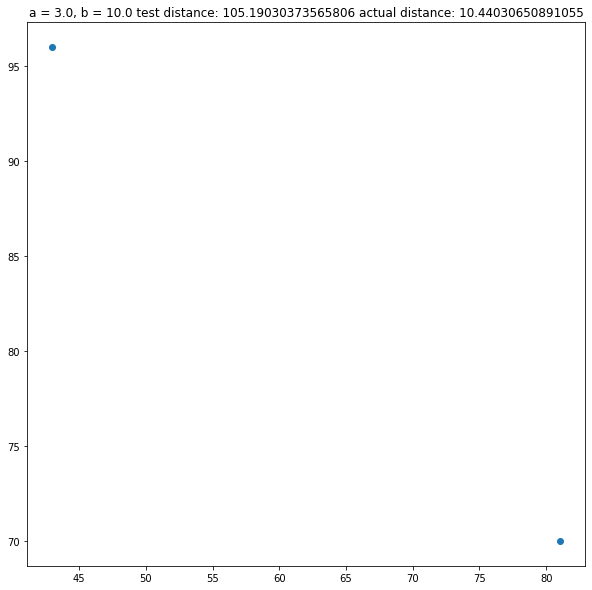

x:  [ 0. 43.]
y:  [ 0. 96.]


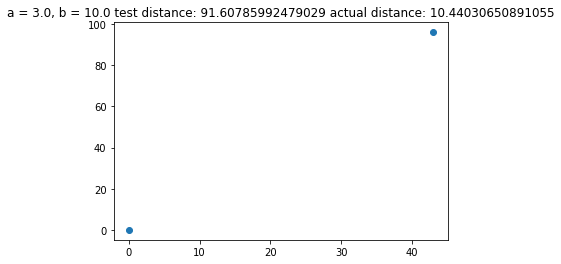

x:  [97. 43.]
y:  [22. 96.]


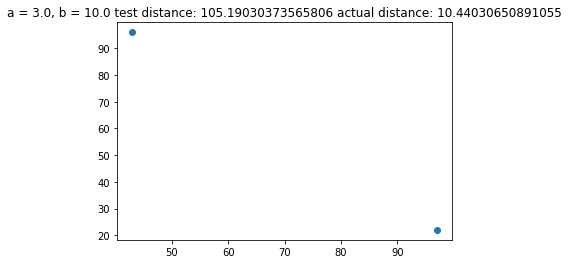

x:  [ 0. 43.]
y:  [ 0. 96.]


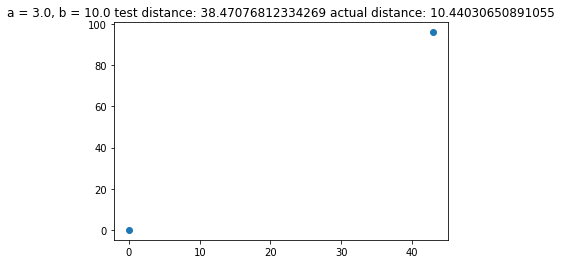

x:  [77. 43.]
y:  [78. 96.]


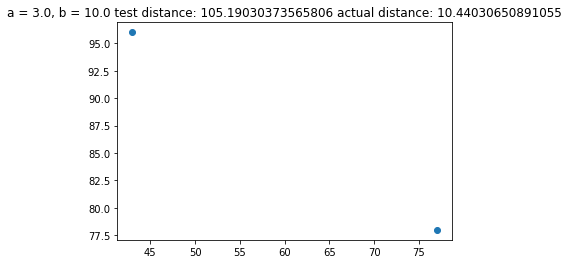

x:  [ 0. 43.]
y:  [ 0. 96.]


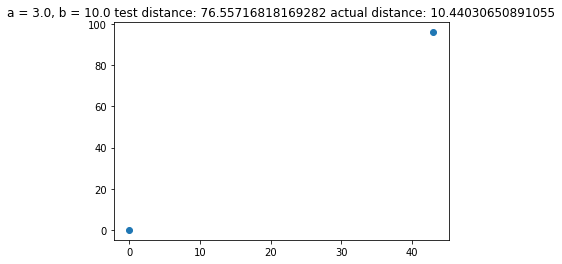

x:  [12. 43.]
y:  [26. 96.]


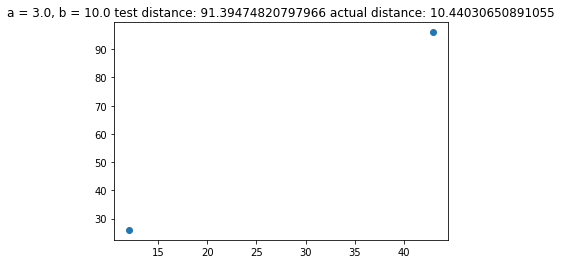

x:  [15. 43.]
y:  [ 9. 96.]


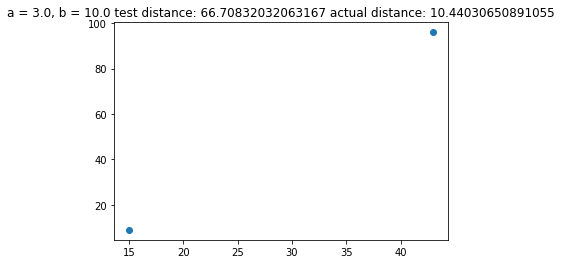

x:  [16. 43.]
y:  [35. 96.]


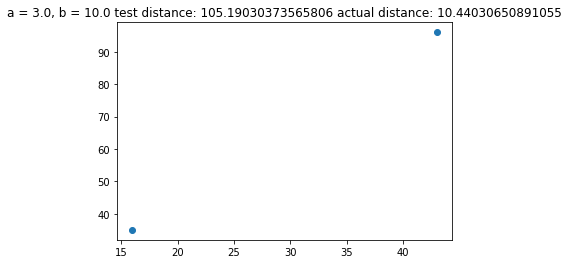

x:  [ 0. 43.]
y:  [ 0. 96.]


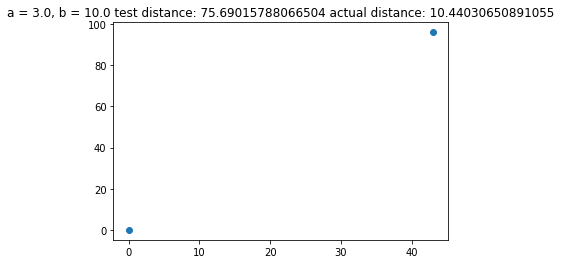

x:  [95. 43.]
y:  [41. 96.]


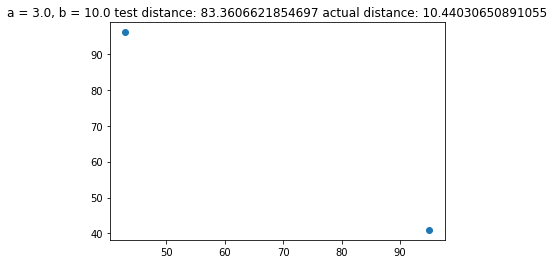

x:  [28. 43.]
y:  [14. 96.]


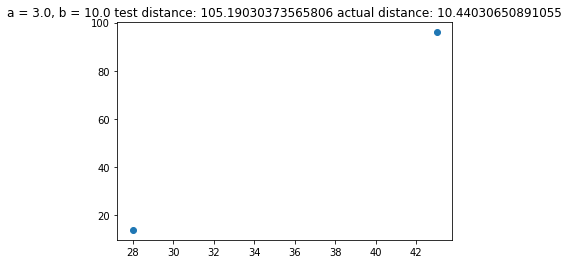

x:  [ 0. 43.]
y:  [ 0. 96.]


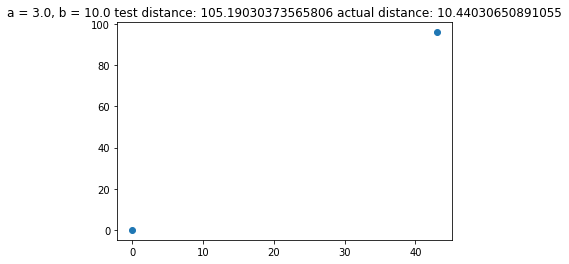

x:  [ 0. 43.]
y:  [ 0. 96.]


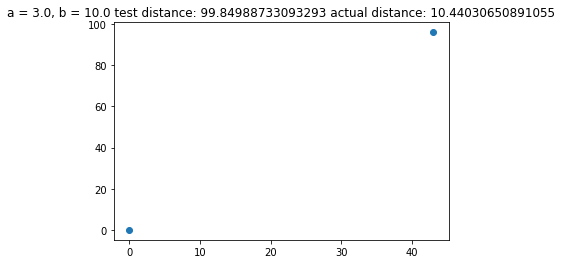

x:  [92. 43.]
y:  [ 9. 96.]


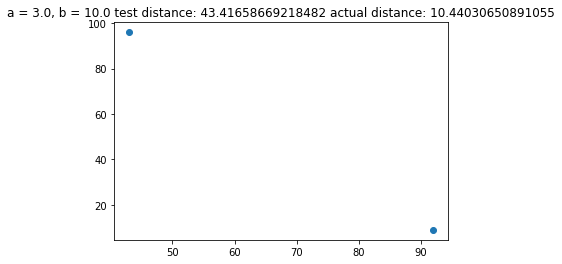

x:  [ 1. 43.]
y:  [85. 96.]


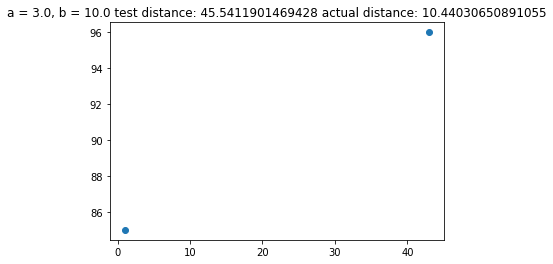

x:  [50. 43.]
y:  [51. 96.]


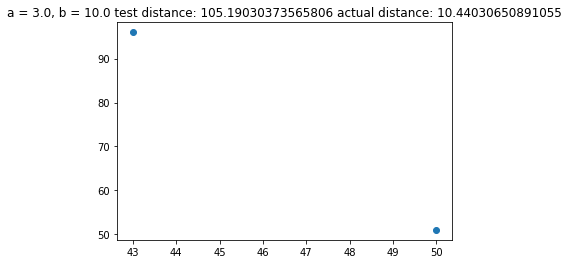

x:  [ 0. 43.]
y:  [ 0. 96.]


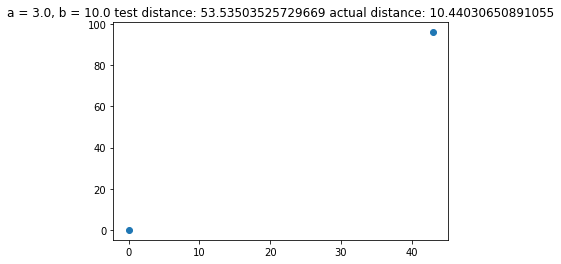

x:  [14. 43.]
y:  [51. 96.]


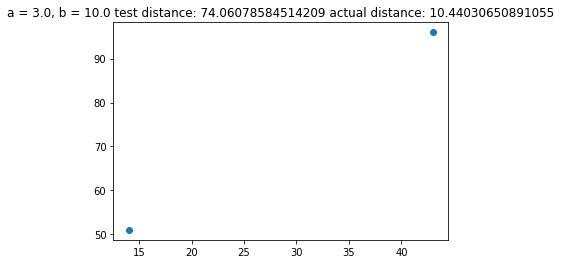

x:  [85. 43.]
y:  [35. 96.]


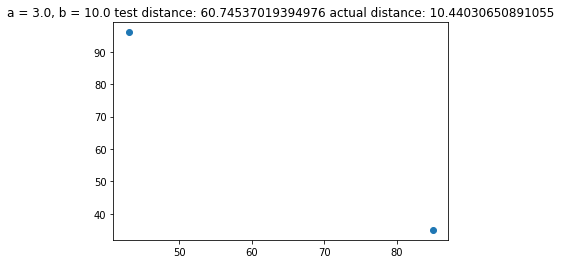

x:  [64. 43.]
y:  [39. 96.]


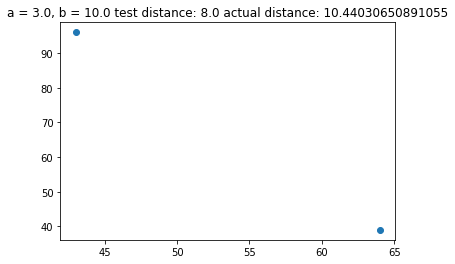

x:  [35. 43.]
y:  [96. 96.]


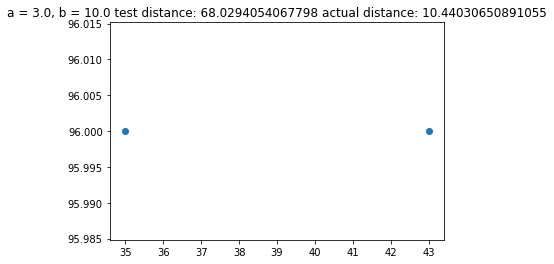

In [16]:
main()